In [3]:
import torch

In [4]:
from torch import nn
from torch.autograd import Variable

In [27]:
import numpy as np
N_train = 5000
# Load Data # replace with something else (also will make .pkl file)
data = np.load('single_locus_data.npy', allow_pickle='TRUE')
# with open("single_locus_data.pkl", "wb") as tf:
#     data = pickle.load(tf)    
f = data.item()['f'][:, None]
t = data.item()['t'][:, None]
p = data.item()['phi'][:, None]
print(len(f))
idx_list = np.arange(len(f))
np.random.shuffle(idx_list)
print(idx_list)

f_train = torch.from_numpy(f[idx_list[:N_train]]).float().to(device)
t_train = torch.from_numpy(t[idx_list[:N_train]]).float().to(device)
p_train = torch.from_numpy(p[idx_list[:N_train]]).float().to(device)
f_test = torch.from_numpy(f[idx_list[N_train:]]).float().to(device)
t_test = torch.from_numpy(t[idx_list[N_train:]]).float().to(device)
p_test = torch.from_numpy(p[idx_list[N_train:]]).float().to(device)


11000
[ 8493   659  2103 ...  4576 10789  2093]


In [18]:
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
device = "cuda:2"
print(f"Using {device} device")
torch.cuda.current_device()

Using cuda:2 device


0

In [38]:
class PINN(nn.Module):
    def __init__(self, layers, s0, N0):
        super().__init__()
        self.model = nn.Sequential().to(device)
        for i in range(len(layers)-2):
            self.model.add_module(f"layer{i}", nn.Linear(layers[i], layers[i+1]))
            self.model.add_module(f"activation{i}", nn.Tanh())
        self.model.add_module(f"layer{len(layers)-1}", nn.Linear(layers[-2], layers[-1]))
        self.model.add_module(f"activation{len(layers)-2}", nn.Softplus())

        self.s = torch.nn.Parameter(torch.tensor(s0).float(), requires_grad = True)
        self.invN = torch.nn.Parameter(torch.tensor(1/N0).float(), requires_grad = True)
        # self.N = torch.nn.Parameter(torch.tensor(N0).float(), requires_grad = True)
        # self.s = Variable(torch.tensor(s0).float(), requires_grad = True).to(device)
        # self.N = Variable(torch.tensor(N0).float(), requires_grad = True).to(device)

    def forward(self, f, t):
        inputs = torch.cat([f, t], 1)
        return self.model(inputs)
    def PDE(self, f, t):
        s = self.s
        invN = self.invN
        p = self.model(torch.cat([f, t], 1))
        p_f = torch.autograd.grad(p.sum(), f, create_graph=True)[0]
        p_t = torch.autograd.grad(p.sum(), t, create_graph=True)[0]
        p_ff = torch.autograd.grad(p_f.sum(), f, create_graph=True)[0]
        g = p_t + s * ((1 - 2*f)*p + (f - f**2)*p_f) + invN / 2 * (-2*p + 2*(1 - 2*f)*p_f + (f - f**2)*p_ff)
        return g

# Input = (f, t) series, Output = p series
model = PINN(layers = [2, 20, 20, 20, 1], s0 = 0.1, N0 = 500).to(device)
        

In [39]:
print(model)
for parameter in model.parameters():

    print(parameter)

PINN(
  (model): Sequential(
    (layer0): Linear(in_features=2, out_features=20, bias=True)
    (activation0): Tanh()
    (layer1): Linear(in_features=20, out_features=20, bias=True)
    (activation1): Tanh()
    (layer2): Linear(in_features=20, out_features=20, bias=True)
    (activation2): Tanh()
    (layer4): Linear(in_features=20, out_features=1, bias=True)
    (activation3): Softplus(beta=1, threshold=20)
  )
)
Parameter containing:
tensor(0.1000, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(0.0020, device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.3419, -0.1134],
        [ 0.6227,  0.2506],
        [-0.0905,  0.1731],
        [ 0.5504,  0.0438],
        [ 0.5020, -0.5935],
        [-0.6329,  0.4117],
        [ 0.6977, -0.5384],
        [-0.6699, -0.2377],
        [ 0.0684, -0.4383],
        [-0.6202, -0.3139],
        [ 0.6478, -0.4465],
        [ 0.2038,  0.5151],
        [ 0.0085, -0.6801],
        [ 0.0721,  0.3841],
        [-0.4766,

In [40]:
print(f_train.shape)
model(f_train, t_train)

torch.Size([5000, 1])


tensor([[0.6500],
        [0.6500],
        [0.6500],
        ...,
        [0.6364],
        [0.6500],
        [0.6717]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [41]:
iterations = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(iterations):
    MSE_loss = nn.MSELoss()
    f_sample = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    pt_f_sample = Variable(torch.from_numpy(f_sample).float(), requires_grad=True).to(device)
    t_sample = np.random.uniform(low=0.0, high=10000, size=(500,1))
    pt_t_sample = Variable(torch.from_numpy(t_sample).float(), requires_grad=True).to(device)
    loss_pde = MSE_loss(model.PDE(pt_f_sample, pt_t_sample), torch.zeros_like(model.PDE(pt_f_sample, pt_t_sample)))
    # In this case, we have p_train to compare directly against estimate of p at f_train, t_train. 
    loss_data = MSE_loss(model(f_train, t_train), p_train)
    loss = loss_pde + loss_data
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    print(epoch,"training loss:", loss.data, "s:", model.s, "N:", 1 / model.invN)


0 training loss: tensor(0.1773, device='cuda:0') s: Parameter containing:
tensor(0.0990, device='cuda:0', requires_grad=True) N: tensor(999.9860, device='cuda:0', grad_fn=<MulBackward0>)
1 training loss: tensor(0.1637, device='cuda:0') s: Parameter containing:
tensor(0.0980, device='cuda:0', requires_grad=True) N: tensor(10439.3809, device='cuda:0', grad_fn=<MulBackward0>)
2 training loss: tensor(0.1516, device='cuda:0') s: Parameter containing:
tensor(0.0970, device='cuda:0', requires_grad=True) N: tensor(-3142.2358, device='cuda:0', grad_fn=<MulBackward0>)
3 training loss: tensor(0.1409, device='cuda:0') s: Parameter containing:
tensor(0.0960, device='cuda:0', requires_grad=True) N: tensor(-2839.6030, device='cuda:0', grad_fn=<MulBackward0>)
4 training loss: tensor(0.1315, device='cuda:0') s: Parameter containing:
tensor(0.0950, device='cuda:0', requires_grad=True) N: tensor(-1602.2446, device='cuda:0', grad_fn=<MulBackward0>)
5 training loss: tensor(0.1233, device='cuda:0') s: Param

In [11]:
# s and N are not updating... why??? ==> solved! self.s and self.N should be torch.nn.Parameter, not Variable.

# Can add to the loss function to keep N non-negative. 

In [42]:
model(f_test, t_test)

tensor([[0.1889],
        [0.0739],
        [0.4350],
        ...,
        [0.0903],
        [0.0377],
        [0.4350]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [43]:
p_test

tensor([[0.1920],
        [0.0711],
        [0.1487],
        ...,
        [0.0925],
        [0.0104],
        [0.1677]], device='cuda:0')

In [14]:
model.N

Parameter containing:
tensor(500.0162, requires_grad=True)

In [15]:
model.s

Parameter containing:
tensor(0.0478, requires_grad=True)

In [16]:
# Return predicted s and N, plot p(f, t). Plot p(f = 1, t), which is fixation probability as a function of time.

In [38]:
import numpy as np

In [39]:
data_FP = np.load("single_locus_FP_fmatrix.npy")
data_FP.shape
data_FP = torch.from_numpy(data_FP).float().to(device)

In [40]:
f_data = data_FP[0, :].reshape(data_FP.shape[1], 1)
t_data = torch.zeros(data_FP.shape[1]).reshape(data_FP.shape[1], 1).to(device)
torch.cat([f_data, t_data], 1)
torch.cat([torch.linspace(0, 1, 1001).reshape(1001, 1), torch.ones(1001, 1)], 1)


tensor([[0.0000, 1.0000],
        [0.0010, 1.0000],
        [0.0020, 1.0000],
        ...,
        [0.9980, 1.0000],
        [0.9990, 1.0000],
        [1.0000, 1.0000]])

In [47]:
class PINN(nn.Module):
    def __init__(self, layers, s0, N0):
        super().__init__()
        self.model = nn.Sequential().to(device)
        for i in range(len(layers)-2):
            self.model.add_module(f"layer{i}", nn.Linear(layers[i], layers[i+1]))
            self.model.add_module(f"activation{i}", nn.Tanh())
        self.model.add_module(f"layer{len(layers)-1}", nn.Linear(layers[-2], layers[-1]))
        self.model.add_module(f"activation{len(layers)-2}", nn.Softplus())

        self.s = torch.nn.Parameter(torch.tensor(s0).float(), requires_grad = True)
        self.invN = torch.nn.Parameter(torch.tensor(1/N0).float(), requires_grad = True)
        # self.N = torch.nn.Parameter(torch.tensor(N0).float(), requires_grad = True)
        # self.s = Variable(torch.tensor(s0).float(), requires_grad = True).to(device)
        # self.N = Variable(torch.tensor(N0).float(), requires_grad = True).to(device)

    def forward(self, f, t):
        inputs = torch.cat([f, t], 1)
        return self.model(inputs)
    def PDE(self, f, t):
        s = self.s
        invN = self.invN
        p = self.model(torch.cat([f, t], 1))
        p_f = torch.autograd.grad(p.sum(), f, create_graph=True)[0]
        p_t = torch.autograd.grad(p.sum(), t, create_graph=True)[0]
        p_ff = torch.autograd.grad(p_f.sum(), f, create_graph=True)[0]
        g = p_t + s * ((1 - 2*f)*p + (f - f**2)*p_f) + invN / 2 * (-2*p + 2*(1 - 2*f)*p_f + (f - f**2)*p_ff)
        return g

# Input = (f, t) series, Output = p series
model = PINN(layers = [2, 20, 20, 20, 1], s0 = 0.1, N0 = 500).to(device)

In [48]:
iterations = 10000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(iterations):
    MSE_loss = nn.MSELoss()
    # Same pde loss as before (pick random f and t to evaluate pde loss)
    f_sample = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    pt_f_sample = Variable(torch.from_numpy(f_sample).float(), requires_grad=True).to(device)
    t_sample = np.random.uniform(low=0.0, high=10000, size=(500,1))
    pt_t_sample = Variable(torch.from_numpy(t_sample).float(), requires_grad=True).to(device)
    loss_pde = MSE_loss(model.PDE(pt_f_sample, pt_t_sample), torch.zeros_like(model.PDE(pt_f_sample, pt_t_sample)))
    loss_data = 0
    for t in np.random.choice(data_FP.shape[0], 20, replace=False):
        f_data = data_FP[t, :].reshape(data_FP.shape[1], 1)
        t_data = t * torch.ones(data_FP.shape[1], 1).to(device)
        # fix the line below so that it is a torch tensor that is updatable as a loss function.
        loss_data += - 1 / data_FP.shape[1] * torch.sum(torch.log(model(f_data, t_data)))
        num_f_step = 1000
        p_left_right = model(torch.linspace(0, 1, num_f_step + 1).reshape(num_f_step + 1, 1).to(device), t * torch.ones(num_f_step + 1, 1).to(device))
        p_integral = torch.sum(p_left_right[1:] + p_left_right[:-1]) / 2 * 1 / num_f_step
        loss_data += p_integral
    # In this case, we have p_train to compare directly against estimate of p at f_train, t_train. 
    loss = 20 * loss_pde + loss_data
    print(epoch,"training loss:", loss.data, "s:", model.s, "N:", 1 / model.invN)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()



0 training loss: tensor(23.1163, device='cuda:2') s: Parameter containing:
tensor(0.1000, device='cuda:2', requires_grad=True) N: tensor(500.0000, device='cuda:2', grad_fn=<MulBackward0>)
1 training loss: tensor(23.0890, device='cuda:2') s: Parameter containing:
tensor(0.0999, device='cuda:2', requires_grad=True) N: tensor(476.1904, device='cuda:2', grad_fn=<MulBackward0>)
2 training loss: tensor(23.0684, device='cuda:2') s: Parameter containing:
tensor(0.0998, device='cuda:2', requires_grad=True) N: tensor(459.7036, device='cuda:2', grad_fn=<MulBackward0>)
3 training loss: tensor(23.0376, device='cuda:2') s: Parameter containing:
tensor(0.0997, device='cuda:2', requires_grad=True) N: tensor(461.1636, device='cuda:2', grad_fn=<MulBackward0>)
4 training loss: tensor(23.0047, device='cuda:2') s: Parameter containing:
tensor(0.0996, device='cuda:2', requires_grad=True) N: tensor(471.2802, device='cuda:2', grad_fn=<MulBackward0>)
5 training loss: tensor(22.9751, device='cuda:2') s: Paramet

In [51]:
model(f_test, t_test)

tensor([[1.1313e+00],
        [3.3778e+00],
        [1.0663e+00],
        ...,
        [3.7696e+00],
        [1.1166e-06],
        [9.2583e+00]], device='cuda:2', grad_fn=<SoftplusBackward0>)

In [52]:
p_test

tensor([[0.6205],
        [0.4682],
        [0.7913],
        ...,
        [0.4577],
        [0.0000],
        [0.2094]], device='cuda:2')

In [68]:
f_plot = np.arange(0, 1, 0.01)
t_plot = np.arange(0, 2000, 1)
ms_f, ms_t = np.meshgrid(f_plot, t_plot)

f = np.ravel(ms_f).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)
pt_f = Variable(torch.from_numpy(f).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_p = model(pt_f, pt_t)

p = pt_p.data.cpu().numpy()
ms_p = p.reshape(ms_f.shape)



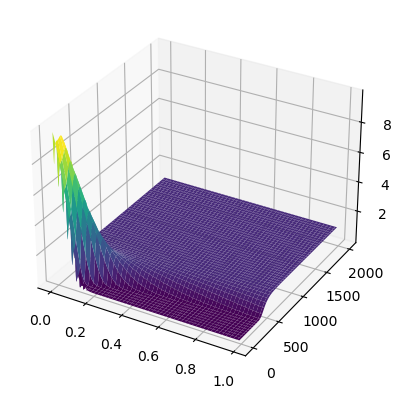

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(ms_f, ms_t, ms_p, cmap='viridis', linewidth=0)

Text(0, 0.5, 'generation (t)')

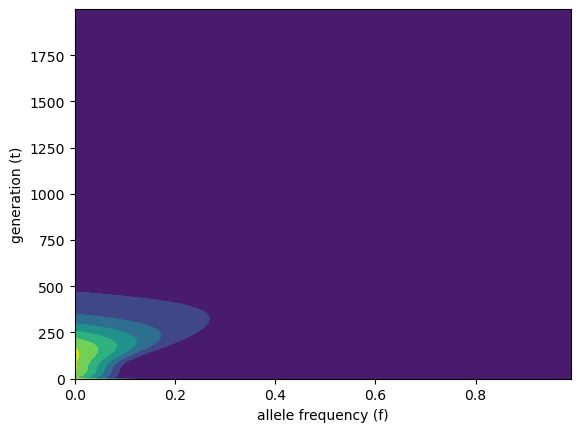

In [71]:
plt.contourf(ms_f, ms_t, ms_p)
plt.xlabel('allele frequency (f)')
plt.ylabel('generation (t)')

In [72]:
model.s

Parameter containing:
tensor(0.0011, device='cuda:2', requires_grad=True)

In [74]:
model.invN

Parameter containing:
tensor(9.6756e-05, device='cuda:2', requires_grad=True)

In [ ]:
## The plot doesn't look too bad?? But the estimate for s is about 1/10 of true value. (true s = 0.01, true N = 1e4)

In [ ]:
## Training is super slow with the new loss function that takes in f and t data.
## Need to implement batch training. It's also time to add mutation, and expand the model to two locus (adds recombination)